#### Imports and Data

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim
import time
from matplotlib.lines import Line2D
from shapely.geometry import LineString
from geopy.distance import geodesic
from shapely.geometry import Point

In [22]:
snowstorm = pd.read_csv('snowstorm_PA.tsv', sep='\t')
counties = pd.read_csv('PA_cities_counties.tsv', sep='\t')

In [23]:
snowstorm.head()

,Location,Low End Snowfall,Expected Snowfall,High End Snowfall,"P>=0.1""","P>=1""","P>=2""","P>=4""","P>=6""","P>=8""","P>=12""","P>=18"""
0,Bethel Park,8,12,15,100%,100%,100%,98%,94%,83%,40%,1%
1,Franklin Park,8,13,16,100%,100%,100%,99%,96%,88%,51%,3%
2,Jefferson Hills,7,11,14,100%,100%,100%,98%,93%,80%,31%,1%
3,Monroeville,7,10,14,100%,100%,100%,99%,94%,81%,32%,1%
4,Moon/Pittsburgh Intl Airport,9,13,16,100%,100%,100%,99%,97%,91%,56%,4%


In [24]:
counties.head()

,Name,Type,County,Class,Population (2018 Estimates),Incorporation date (as city),Sq Miles
0,Aliquippa,City,Beaver,Third,8908,1987,4.19
1,Allentown,City,Lehigh,Third,123828,1867,17.55
2,Altoona,City,Blair,Third,43702,1868,9.91
3,Arnold,City,Westmoreland,Third,4980,1939,0.73
4,Beaver Falls,City,Beaver,Third,8387,1928,2.13


#### Reading the Zip Files

In [25]:
counties_gdf = gpd.read_file("tl_2021_us_county.zip")
municipalities_gdf = gpd.read_file("PaMunicipalities2022_01.zip")

#### Copying in The Functions

In [26]:
def add_area_and_label_coords(some_gdf):
    some_gdf['area'] = some_gdf.area
    some_gdf['coords'] = some_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    some_gdf['coords'] = [coords[0] for coords in some_gdf['coords']]

In [27]:
def plot_with_labels(some_gdf, ax, name_col=None, field_col=None, **kwargs):
    if field_col is None:
        some_gdf.plot(ax=ax, **kwargs)
    else:
        some_gdf.plot(column=field_col, ax=ax, legend=True, **kwargs)
    if name_col is not None:
        for idx, row in some_gdf.iterrows():
            ax.annotate(text=row[name_col], xy=row['coords'],
                         horizontalalignment='center')

In [28]:
def calc_overall_centroid(some_gdf):
    """
    Use the 'coords' and 'area' columns to estimate an overall centroid
    """
    sum_x = 0.0
    sum_y = 0.0
    sum_area = 0.0
    for idx, row in some_gdf.iterrows():
        coord_x, coord_y = row['coords']
        sum_x += coord_x * row['area']
        sum_y += coord_y * row['area']
        sum_area += row['area']
    centroid_x = sum_x / sum_area
    centroid_y = sum_y / sum_area
    return centroid_x, centroid_y

In [29]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees).  All args
    must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

#### Setting up an Ortho Projection for PA

In [30]:
gdf = counties_gdf[counties_gdf.STATEFP=='42']  
gdf.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
19,42,007,01214112,42007,Beaver,Beaver County,06,H1,G4020,430,38300,None,A,1125854819,24162295,+40.6841401,-080.3507209,"POLYGON ((-80.27803 40.53674, -80.29151 40.527..."
47,42,053,01213669,42053,Forest,Forest County,06,H1,G4020,None,None,None,A,1106595595,8369675,+41.5133040,-079.2497050,"POLYGON ((-78.9586 41.52549, -78.95861 41.5251..."
95,42,117,01209189,42117,Tioga,Tioga County,06,H1,G4020,None,None,None,A,2936765818,8279717,+41.7668593,-077.2572881,"POLYGON ((-77.21159 41.54544, -77.21177 41.545..."


In [31]:
add_area_and_label_coords(gdf)
centroid_x, centroid_y = calc_overall_centroid(gdf)
print(centroid_x, centroid_y)

-77.84058346055701 40.900430189750736


/var/folders/lx/x0t3rbk93g9_mdb6qn8w_d100000gn/T/ipykernel_2245/4182452352.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area
/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [32]:
lat = centroid_y
lon = centroid_x
CRS.from_proj4(f"+proj=ortho +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")

<Projected CRS: +proj=ortho +lat_0=40.900430189750736 +lon_0=-77.8 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Orthographic
Datum: Unknown based on Normal Sphere (r=6370997) ellipsoid
- Ellipsoid: Normal Sphere (r=6370997)
- Prime Meridian: Greenwich

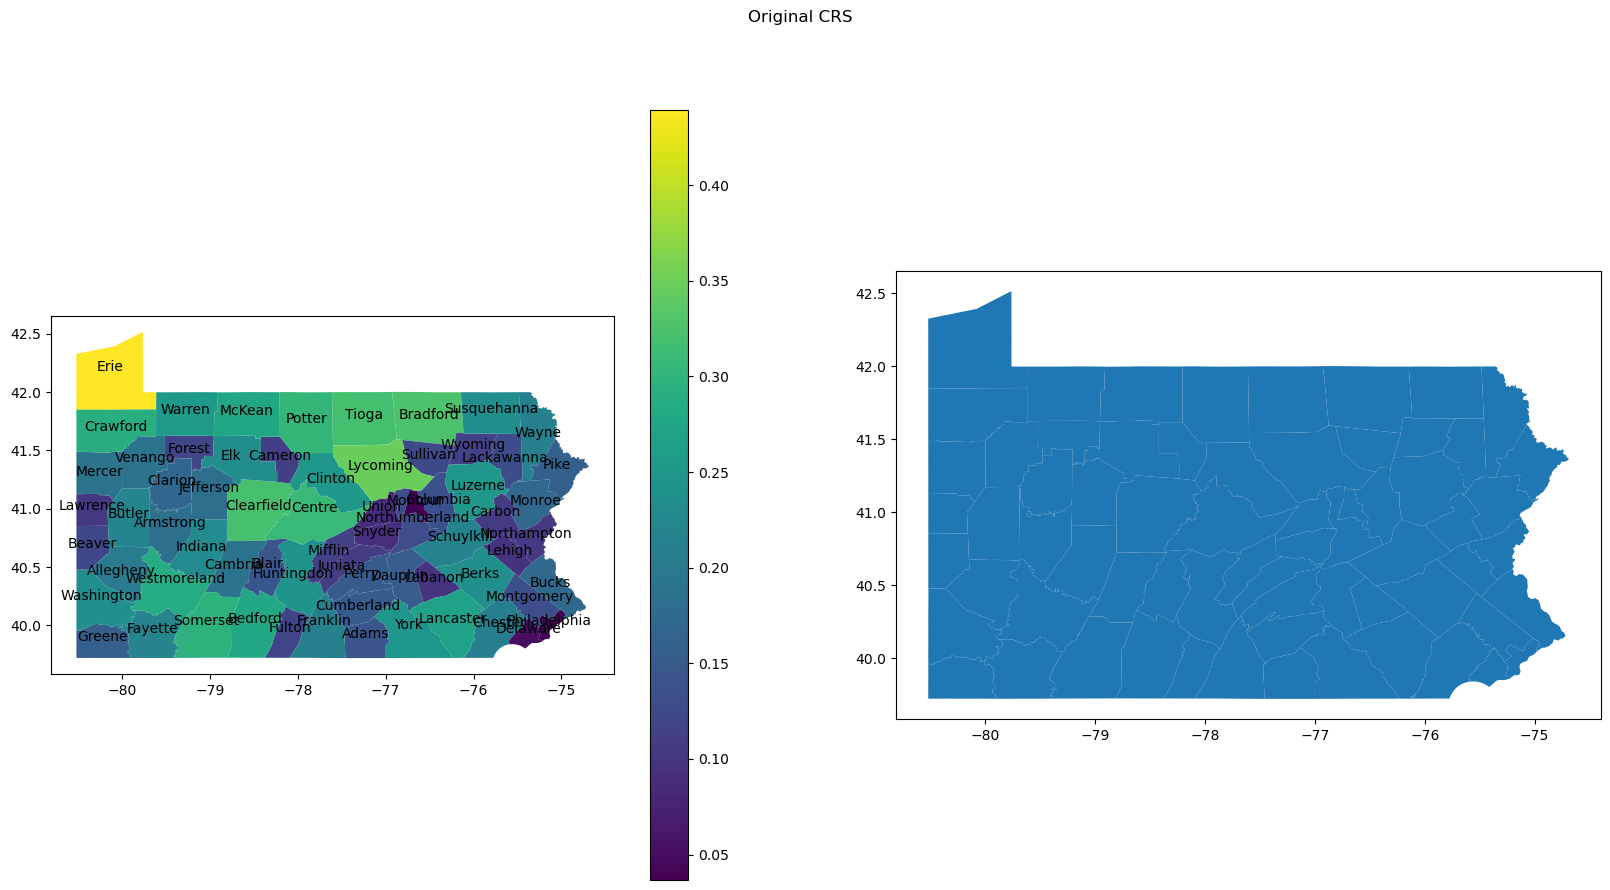

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plot_with_labels(gdf, field_col='area', name_col='NAME', ax=axes[0])
plot_with_labels(gdf, ax=axes[1])
fig.suptitle('Original CRS')

plt.show()

#### Estimating County-Wise Snowfall

In [34]:
merged_df = pd.merge(snowstorm, counties[['Name', 'County']], left_on="Location", right_on="Name", how="left")
merged_df.head()

,Location,Low End Snowfall,Expected Snowfall,High End Snowfall,"P>=0.1""","P>=1""","P>=2""","P>=4""","P>=6""","P>=8""","P>=12""","P>=18""",Name,County
0,Bethel Park,8,12,15,100%,100%,100%,98%,94%,83%,40%,1%,NaN,NaN
1,Franklin Park,8,13,16,100%,100%,100%,99%,96%,88%,51%,3%,NaN,NaN
2,Jefferson Hills,7,11,14,100%,100%,100%,98%,93%,80%,31%,1%,NaN,NaN
3,Monroeville,7,10,14,100%,100%,100%,99%,94%,81%,32%,1%,NaN,NaN
4,Moon/Pittsburgh Intl Airport,9,13,16,100%,100%,100%,99%,97%,91%,56%,4%,NaN,NaN


In [35]:
merged_df.drop(columns=["Name"], inplace=True)

In [36]:
missing_counties = merged_df[merged_df["County"].isna()]["Location"].unique()
print("Cities missing county info:")
print(missing_counties[:10])

Cities missing county info:
['Bethel Park' 'Franklin Park' 'Jefferson Hills' 'Monroeville'
 'Moon/Pittsburgh Intl Airport' 'Mount Lebanon' 'Penn Hills' 'Apollo'
 'Ford City' 'Freeport']


In [37]:
geolocator = Nominatim(user_agent="ms-das-viz")

locations = []

for city in missing_counties:
    location = geolocator.geocode(f"{city}, Pennsylvania, US")
    
    if location:
        address = location.address.split(",")
        city_part = next((part for part in address if "County" in part), None)
        city_name = city_part.split()[0] if city_part else None
        locations.append(city_name)
    
    else:
        locations.append(None)
    
    time.sleep(1)

In [38]:
missing_indices = merged_df[merged_df['County'].isna()].index
merged_df.loc[missing_indices, "County"] = locations

In [39]:
merged_df.head()

,Location,Low End Snowfall,Expected Snowfall,High End Snowfall,"P>=0.1""","P>=1""","P>=2""","P>=4""","P>=6""","P>=8""","P>=12""","P>=18""",County
0,Bethel Park,8,12,15,100%,100%,100%,98%,94%,83%,40%,1%,Allegheny
1,Franklin Park,8,13,16,100%,100%,100%,99%,96%,88%,51%,3%,Allegheny
2,Jefferson Hills,7,11,14,100%,100%,100%,98%,93%,80%,31%,1%,Allegheny
3,Monroeville,7,10,14,100%,100%,100%,99%,94%,81%,32%,1%,Allegheny
4,Moon/Pittsburgh Intl Airport,9,13,16,100%,100%,100%,99%,97%,91%,56%,4%,None


In [40]:
pruned_df = merged_df[["Location", "County", "Expected Snowfall"]]
pruned_df.head()

,Location,County,Expected Snowfall
0,Bethel Park,Allegheny,12
1,Franklin Park,Allegheny,13
2,Jefferson Hills,Allegheny,11
3,Monroeville,Allegheny,10
4,Moon/Pittsburgh Intl Airport,None,13


In [41]:
grouped_df = pruned_df.groupby("County")["Expected Snowfall"].mean()
grouped_df.head()

County
Allegheny    11.571429
Armstrong     9.500000
Beaver       12.400000
Butler       12.200000
Clarion      11.500000
Name: Expected Snowfall, dtype: float64

#### Merging the Snowfall data into the GeoDataFrame

In [42]:
snowfall_gdf = gdf.merge(grouped_df, left_on="NAME", right_index=True, how="left")
snowfall_gdf.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area,coords,Expected Snowfall
19,42,007,01214112,42007,Beaver,Beaver County,06,H1,G4020,430,...,None,A,1125854819,24162295,+40.6841401,-080.3507209,"POLYGON ((-80.27803 40.53674, -80.29151 40.527...",0.122502,"(-80.33356401630434, 40.6665865)",12.4
47,42,053,01213669,42053,Forest,Forest County,06,H1,G4020,None,...,None,A,1106595595,8369675,+41.5133040,-079.2497050,"POLYGON ((-78.9586 41.52549, -78.95861 41.5251...",0.120257,"(-79.23552915941254, 41.475388499999994)",12.0
95,42,117,01209189,42117,Tioga,Tioga County,06,H1,G4020,None,...,None,A,2936765818,8279717,+41.7668593,-077.2572881,"POLYGON ((-77.21159 41.54544, -77.21177 41.545...",0.318905,"(-77.25034505294256, 41.771712)",NaN


#### Plotting the Snowfall Map

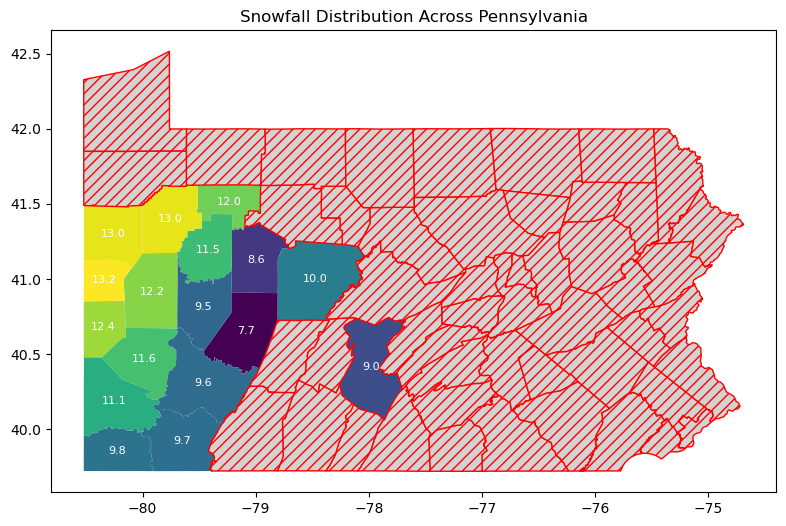

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))

snowfall_gdf.plot(
    column="Expected Snowfall", 
    ax=ax,
    missing_kwds={
        "color": "lightgrey", 
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
)

for idx, row in snowfall_gdf.iterrows():
    centroid = row['geometry'].centroid
    snowfall_value = row['Expected Snowfall']
    if not pd.isna(snowfall_value):
        ax.annotate(
            text=f"{snowfall_value:.1f}", 
            xy=(centroid.x, centroid.y),  
            ha='center',  
            va='center', 
            fontsize=8,   
            color='white' 
        )

ax.set_title("Snowfall Distribution Across Pennsylvania")

plt.show()

#### Travel Distances

In [47]:
municipalities_gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [48]:
municipalities_gdf_ortho = municipalities_gdf.to_crs(epsg=5070)
municipalities_gdf_ortho.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [49]:
municipalities_gdf_pc = municipalities_gdf.to_crs(epsg=4326)
municipalities_gdf_pc.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
municipalities_gdf_pc.head(3)

,MSLINK,COUNTY,MUNICIPAL_,MUNICIPAL1,FIPS_MUN_C,FED_AID_UR,FIPS_COUNT,FIPS_AREA_,FIPS_NAME,FIPS_SQ_MI,...,FED_ID_NUM,CLASS_OF_M,GIS_UPDATE,GIS_GEOMET,GPID,GEOMETRY_A,GEOMETRY_L,Shape_Leng,Shape_Area,geometry
0,2254,59,209,WEST BUFFALO,82640,1,119,00000,None,38.2,...,24-6001593,2TWP,0000/00/00,0000/00/00,33785,0.0,0.0,74680.772799,1.773021e+08,"MULTIPOLYGON (((-77.02752 41.02883, -77.02704 ..."
1,1258,21,203,HOPEWELL,35672,1,041,00000,None,28.2,...,23-2131817,2TWP,0000/00/00,0000/00/00,33786,0.0,0.0,55735.307406,1.241206e+08,"POLYGON ((-77.48381 40.12431, -77.48454 40.123..."
2,2255,59,210,WHITE DEER,84496,2,119,50016,MILTON,30.6,...,24-6001596,2TWP,0000/00/00,0000/00/00,33787,0.0,0.0,63730.550468,2.107778e+08,"POLYGON ((-76.86164 41.02629, -76.86184 41.025..."


#### Travel Map

In [51]:
travel_towns = ['PITTSBURGH', 'SCRANTON', 'ALLENTOWN', 'PHILADELPHIA', 'HARRISBURG', 'PITTSBURGH']
travel_gdf = municipalities_gdf_pc[municipalities_gdf_pc['MUNICIPAL1'].isin(travel_towns)]
travel_gdf.head()

,MSLINK,COUNTY,MUNICIPAL_,MUNICIPAL1,FIPS_MUN_C,FED_AID_UR,FIPS_COUNT,FIPS_AREA_,FIPS_NAME,FIPS_SQ_MI,...,FED_ID_NUM,CLASS_OF_M,GIS_UPDATE,GIS_GEOMET,GPID,GEOMETRY_A,GEOMETRY_L,Shape_Leng,Shape_Area,geometry
79,2140,02,301,PITTSBURGH,61000,4,003,00009,PITTSBURGH,58.2,...,25-6000879,CITY,0000/00/00,0000/00/00,34021,0.0,0.0,161680.100738,2.609306e+08,"POLYGON ((-80.07195 40.46127, -80.07159 40.461..."
346,1212,22,301,HARRISBURG,32800,4,043,00083,HARRISBURG,11.6,...,23-6002010,CITY,0000/00/00,0000/00/00,33456,0.0,0.0,44248.628005,5.200551e+07,"POLYGON ((-76.83964 40.25856, -76.83993 40.258..."
701,852,35,302,SCRANTON,69000,4,069,00281,SCRAN/WLKS-BARRE,26.0,...,24-6000704,CITY,0000/00/00,0000/00/00,33766,0.0,0.0,70454.442512,1.172628e+08,"POLYGON ((-75.69208 41.37187, -75.69466 41.373..."
1568,2573,67,301,PHILADELPHIA,60000,4,101,00004,PHILADELPHIA,143.0,...,23-6003047,CITY,0000/00/00,0000/00/00,34751,0.0,0.0,157206.179534,6.297380e+08,"POLYGON ((-75.01104 40.02172, -75.01129 40.021..."
2145,703,39,301,ALLENTOWN,02000,4,077,00068,LEHIGH VALLEY,18.3,...,23-6003116,CITY,0000/00/00,0000/00/00,35178,0.0,0.0,81221.859145,8.098603e+07,"POLYGON ((-75.50007 40.61343, -75.49867 40.613..."


/var/folders/lx/x0t3rbk93g9_mdb6qn8w_d100000gn/T/ipykernel_2245/2282602149.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ordered_travel_coords = list(ordered_travel_gdf.geometry.centroid.apply(lambda p: (p.x, p.y)))


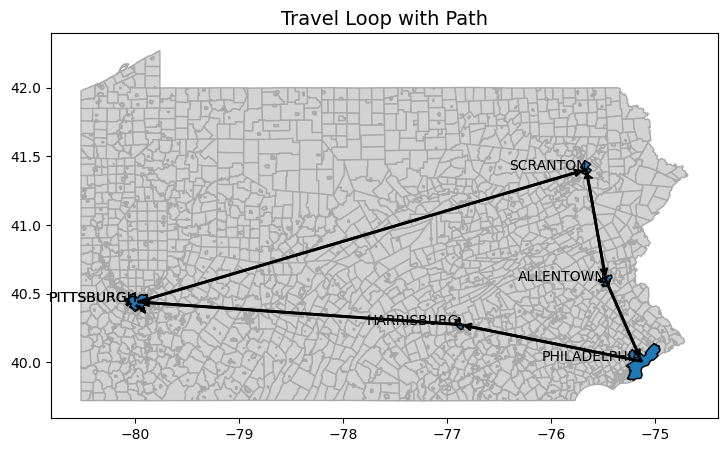

In [55]:
ordered_travel_gdf = travel_gdf.set_index('MUNICIPAL1').reindex(travel_towns).reset_index()
ordered_travel_gdf = ordered_travel_gdf[ordered_travel_gdf.geometry.notnull()]
ordered_travel_coords = list(ordered_travel_gdf.geometry.centroid.apply(lambda p: (p.x, p.y)))

travel_path = gpd.GeoDataFrame(geometry=[LineString(ordered_travel_coords)], crs=municipalities_gdf_pc.crs)

fig, ax = plt.subplots(figsize=(15, 5))
municipalities_gdf_pc.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
ordered_travel_gdf.plot(ax=ax, edgecolor='black', markersize=50)
travel_path.plot(ax=ax, color='black', linewidth=2)

for idx, row in ordered_travel_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['MUNICIPAL1'], fontsize=10, ha="right", color="black")

for i in range(len(ordered_travel_coords) - 1):
    start = ordered_travel_coords[i]
    end = ordered_travel_coords[i + 1]
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", color="black", lw=2))

plt.title("Travel Loop with Path", fontsize=14)
plt.show()

#### Travel Distance

In [62]:
centroids_4326 = ordered_travel_gdf.to_crs(epsg=4326).geometry.centroid
centroid_lat, centroid_lon = centroids_4326.y.mean(), centroids_4326.x.mean()

ortho_crs = CRS.from_proj4(f"+proj=ortho +lat_0={centroid_lat} +lon_0={centroid_lon} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")
ordered_travel_gdf_ortho = ordered_travel_gdf.to_crs(ortho_crs)

orthogonal_distances = []
for i in range(len(ordered_travel_gdf_ortho) - 1):
    start = ordered_travel_gdf_ortho.iloc[i]
    end = ordered_travel_gdf_ortho.iloc[i + 1]
    distance = start.geometry.centroid.distance(end.geometry.centroid)
    orthogonal_distances.append(distance)

total_orthogonal_distance = sum(orthogonal_distances)
print(f"Total travel distance (Orthogonal Projection): {round(total_orthogonal_distance/1000, 2)} km")

ordered_travel_gdf_pc = ordered_travel_gdf.to_crs(epsg=4326)
haversine_distances = []
for i in range(len(ordered_travel_gdf_pc) - 1):
    start = ordered_travel_gdf_pc.iloc[i]
    end = ordered_travel_gdf_pc.iloc[i + 1]
    start_lon, start_lat = start.geometry.centroid.x, start.geometry.centroid.y
    end_lon, end_lat = end.geometry.centroid.x, end.geometry.centroid.y
    distance = haversine_np(start_lon, start_lat, end_lon, end_lat)
    haversine_distances.append(distance)

total_haversine_distance = sum(haversine_distances)
print(f"Total travel distance (Haversine, Platte Carree Projection): {round(total_haversine_distance, 2)} km")

Total travel distance (Orthogonal Projection): 954.76 km
Total travel distance (Haversine, Platte Carree Projection): 954.32 km


/var/folders/lx/x0t3rbk93g9_mdb6qn8w_d100000gn/T/ipykernel_2245/491991858.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_4326 = ordered_travel_gdf.to_crs(epsg=4326).geometry.centroid


##### Reasons for Why the Values Differ: 
##### The Haversine distance is slightly smaller than the orthogonal projection distance because the Haversine formula calculates the great-circle distance on a spherical Earth, accounting for its curvature and providing the true shortest path between two points. In contrast, the orthogonal projection (EPSG:3857) assumes a flat plane, distorting distances, especially at higher latitudes, and resulting in longer calculated paths. This distortion explains why the orthogonal distance is slightly larger than the Haversine distance.